In [6]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
env = gym.make('CartPole-v1')


print('observation space: ', env.observation_space)
print('action space: ', env.action_space)

observation space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space:  Discrete(2)


In [56]:
GAMMA = 0.99
TIMESTEPS = 500
PRINT_EVERY = 100

REWARD_THRESHOLD = env.spec.reward_threshold
NUM_EPISODES = 2000

In [10]:
SEED = 1234

env.reset(seed = SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Policy Network for Without Baseline Case

In [11]:
class Policy(nn.Module):
    """Policy without baseline for actor and critic
    """

    def __init__(self, state_size= env.observation_space.shape[0], action_size=env.action_space.n, hidden_size=128, dropout = 0.5):
        super(Policy, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.affine1 = nn.Linear(state_size, hidden_size)

        #actor's layer
        self.action_head = nn.Linear(hidden_size, action_size)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []


    def forward(self, state):
        x = self.affine1(state)
        # x = self.dropout(x)
        x = F.relu(x)
        action_prob = self.action_head(x)

        return action_prob

    def select_action(self, state):
        state = torch.tensor(state).to(device)
        action_probs = self.forward(state)  # Call the forward method

        action_probs = F.softmax(action_probs, dim=-1).to(device)  # Applying softmax to obtain valid probabilities

        #Sampling action
        dist = Categorical(action_probs)
        action = dist.sample()

        self.saved_actions.append(dist.log_prob(action))
        return action.item(), dist.log_prob(action)


### Policy network for Baseline Case

In [12]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
class PolicyForBaseline(nn.Module):
    """
    Policy with baseline for actor and critic
    """

    def __init__(self, state_size = env.observation_space.shape[0], action_size = env.action_space.n, hidden_size  = 128, dropout = 0.5):
        super(PolicyForBaseline, self).__init__()
        self.dropout = nn.Dropout(dropout)

        #base layer
        self.affine1 = nn.Linear(state_size, hidden_size)

        #actor's layer
        self.action_head = nn.Linear(hidden_size, action_size)


        #critic's layer
        self.value_head = nn.Linear(hidden_size,1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, state):
        x = self.affine1(state)
        x = F.relu(x)

        action_prob = self.action_head(x)

        state_values = self.value_head(x)

        return action_prob, state_values
    
    def select_action(self, state):
        state = torch.tensor(state).to(device)
        action_probs, state_values = self.forward(state)   #Forward pass for the current state
        action_probs = F.softmax(action_probs, dim=-1).to(device)

        #sampling action
        dist = Categorical(action_probs)
        action = dist.sample()

        self.saved_actions.append(SavedAction(dist.log_prob(action), state_values))

        return action.item(), dist.log_prob(action)

### Reinforce Class

In [71]:

class Reinforce():
    def __init__(self, env, policy, optimizer,baseline: bool, break_at_threshold = False, seed = None, gamma = GAMMA, max_t = TIMESTEPS, print_every = PRINT_EVERY, reward_threshold = REWARD_THRESHOLD):
        self.env = env
        self.policy = policy
        self.optimizer = optimizer
        self.gamma = gamma
        self.reward_threshold = reward_threshold
        self.baseline = baseline
        self.seed = seed
        self.break_at_threshold = break_at_threshold

    def train(self,episode, max_t = 500 ):
        self.policy.train()
        saved_log_probs = []
        rewards = []
        done = False
        episode_reward = 0

        # Use the seed if provided
        state = self.env.reset(seed = self.seed)
        state = state[0]
        next_state = state

        for t in range(max_t):
            current_state = next_state

            #Sample action for current state
            action, log_prob = self.policy.select_action(current_state)
            saved_log_probs.append(log_prob)

            #Get next state, and the reward
            next_state, reward, done, _, _ = self.env.step(action)

            rewards.append(reward)
            self.policy.rewards.append(reward)

            episode_reward += reward
            if done:
                break
        
        #Calculate returns for the episode
        returns = self.calculate_returns(rewards, episode)

        #Optimise policy and value losses
        if self.baseline:
            self.optimize_policy_with_baseline(returns)
        else:
            self.optimise_policy_without_baseline(returns)

        return episode_reward
    
    def calculate_returns(self, rewards, episode, normalize = True):
        returns =[]
        R = 0
        for r in self.policy.rewards[::-1]:

            #TD(0) update step
            R = r + self.gamma*R
            returns.insert(0,R)
        returns = torch.tensor(returns).float()

        if normalize:
            returns = (returns - returns.mean()) / (returns.std() + episode)
        return returns
    
    def optimize_policy_with_baseline(self, returns):
        policy_losses = []
        value_losses = []
        saved_actions = self.policy.saved_actions

        for (log_prob, value), R in zip(saved_actions, returns):
            #TD error
            delta = R - value.item()

            #calculate actor(policy) loss
            policy_losses.append(-log_prob*delta.item())
            
            #calculate critic(value) loss
            value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).to(device)))

        #Calculating loss(policy loss+ value loss) and perform backpropagation
        torch.autograd.set_detect_anomaly(True)
        self.optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum() 
        loss.backward(retain_graph=True)
        self.optimizer.step()

        # reset rewards and action buffer 
        del self.policy.rewards[:]
        del self.policy.saved_actions[:]

    def optimise_policy_without_baseline(self, returns):

        policy_losses = []
        saved_actions = self.policy.saved_actions

        for log_prob, R in zip(saved_actions, returns):
            policy_losses.append(-log_prob*R)

        if policy_losses:
            policy_loss = torch.stack(policy_losses).sum()
        else:
            policy_loss = torch.tensor(0.0)

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        # reset rewards and action buffer 
        del self.policy.rewards[:]
        del self.policy.saved_actions[:]
        
    def episode_run(self, n_episodes, print_every = PRINT_EVERY):
        running_reward = 10
        episode_rewards = []

        counter = 0
        for episode in range(1, n_episodes):

            #Train 
            episode_reward = self.train(episode)
            episode_rewards.append(episode_reward)
            
            # update cumulative reward
            running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
            
            # log results
            if episode % print_every == 0:
                print(f'| Episode: {episode:3} | Mean Rewards: {running_reward:5.1f}|')
            
            # check if we have "solved" the cart pole problem
            if running_reward >= REWARD_THRESHOLD:
                if counter < 1:
                    print(f'Reached reward threshold in {episode} episodes')
                    self.winning_episode = episode
                    counter+=1
                    self.winning_episode = (episode)
                
                if self.break_at_threshold:
                    break

        return episode_rewards
    
    def PerformExperiments(self, n_experiments):
        exp_wise_rewards = []
        winning_episodes = []
        for i in range(n_experiments):
            print("Experiment no. : ", i+1)
            self.winning_episode = 0

            # Use a different seed for each experiment
            self.seed = self.seed + 1 if self.seed is not None else None

            episodic_rewards= self.episode_run(n_episodes = NUM_EPISODES, print_every = 10)
            exp_wise_rewards.append(episodic_rewards)
            winning_episodes.append(self.winning_episode)
        mean_reward_exp = np.mean(exp_wise_rewards, axis = 0)
        var_reward_exp = np.var(exp_wise_rewards, axis = 0)

        #plot
        plt.figure(figsize=(12,8))

        plt.plot(mean_reward_exp, label='Train Reward')
        plt.xlabel('Episode', fontsize=20)
        plt.ylabel('Reward', fontsize=20)
        plt.hlines(REWARD_THRESHOLD, 0, len(mean_reward_exp), color='r')
        plt.legend(loc='lower right')
        plt.grid()

        return mean_reward_exp, var_reward_exp, winning_episodes
    

    def Plot(mean_reward_exp, var_reward_exp):
        # Plot mean episodic return with shaded regions representing variance for variant 1
        plt.plot(range(1, len(mean_reward_exp) + 1), mean_reward_exp, label='Mean Return', color='blue')
        plt.fill_between(range(1, len(mean_reward_exp) + 1), mean_reward_exp - np.sqrt(var_reward_exp),
                        mean_reward_exp + np.sqrt(var_reward_exp), color='blue', alpha=0.1)

#### BOHB (Bayesian Optimization Hyperband)  - Hyper-parameter Tuning for without Baseline Case

In [ ]:
#HYPERPARAMETER TUNING FOR LEARNING RATE  - WITHOUT BASELINE

from bohb import BOHB
import bohb.configspace as cs

SEED = 123

if __name__ == '__main__':
    np.random.seed(SEED)

    #defining objective function
    def evaluate(params,budget):


        print("budget: ", budget)

        policy = Policy().to(device)
        optimizer = torch.optim.Adam(policy.parameters(), lr=params['lr'])
        agent = Reinforce(env, policy, optimizer, baseline=False, seed=1234, break_at_threshold=True)
        episode_rewards, _ = agent.episode_run(n_episodes=budget, print_every=100)

        #returning negative rewards as loss and minimizing the loss (or maximizing the mean rewards for all episodes)
        return -np.mean(episode_rewards)

    learning_rate = cs.UniformHyperparameter('lr', 1e-4, 1e-1, log=True)
    configspace = cs.ConfigurationSpace([learning_rate])

    print(f"Learning rate: {learning_rate}")

    opt = BOHB(configspace, evaluate, max_budget=2000, min_budget=1, n_proc=1)

    

    logs = opt.optimize()
    print(logs)

Extracting the best parameters configuration

In [ ]:
# Initialize variables to store best loss and corresponding learning rate
best_loss = float('inf')
best_lr = None

# Iterate through the log entries
for entry in logs:
    entry = list(entry.values())[0]
    print((entry))
    loss = entry['loss']
    print(entry['hyperparameter'])
    print(loss)
    if loss < best_loss:
        best_loss = loss
        best_lr = entry['hyperparameter']

# Print the best learning rate
best_lr = (best_lr)

print("Best learning rate:", best_lr)

##### BOHB (Bayesian Optimization Hyperband)  - Hyper-parameter tuning for Basline Case

In [ ]:
#HYPERPARAMTER TUNING FOR LEARNING RATE - WITH BASELINE

from bohb import BOHB
import bohb.configspace as cs

SEED = 123

if __name__ == '__main__':
    np.random.seed(SEED)

    # Defining objective function
    def evaluate(params,budget):
        print("budget: ", budget)

        policy = PolicyForBaseline().to(device)
        optimizer = torch.optim.Adam(policy.parameters(), lr=params['lr'])
        agent = Reinforce(env, policy, optimizer, baseline=True, seed=1234, break_at_threshold=True)
        episode_rewards, _ = agent.episode_run(n_episodes=budget, print_every=100)

        #returning negative rewards as loss and minimizing the loss (or maximizing the mean rewards for all episodes)
        return -np.mean(episode_rewards)

    learning_rate = cs.UniformHyperparameter('lr', 1e-4, 1e-1, log=True)
    configspace = cs.ConfigurationSpace([learning_rate])

    print(f"Learning rate: {learning_rate}")

    opt = BOHB(configspace, evaluate, max_budget=666, min_budget=100, n_proc=1)

    logs_baseline = opt.optimize()
    print(logs_baseline)

Extracting the best parameter configuration

In [ ]:
best_loss_baseline = float('inf')
best_lr_baseline = None

for entry in logs_baseline:
    
    entry = list(entry.values())[0]
    print((entry))
    loss = entry['loss']
    print(entry['hyperparameter'])
    print(loss)
    if loss < best_loss_baseline:
        best_loss_baseline = loss
        best_lr_baseline = entry['hyperparameter']

# Print the best learning rate
best_lr_baseline = (best_lr_baseline)

print("Best learning rate:", best_lr_baseline)

#### Defining Policies

In [72]:
#best_lr value is 0.0070040529447036752
policy_for_baseline = PolicyForBaseline().to(device)
optimizer_for_baseline = optim.Adam(policy_for_baseline.parameters(), lr = 0.0070040529447036752)

In [57]:
#best_lr value is 0.004301886382597813
policy_without_baseline = Policy().to(device)
optimizer_without_baseline = optim.Adam(policy_without_baseline.parameters(), lr = 0.004301886382597813)

#### Initializing Weights

In [59]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)


policy_without_baseline.apply(init_weights)

Policy(
  (dropout): Dropout(p=0.5, inplace=False)
  (affine1): Linear(in_features=4, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=2, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

In [63]:
policy_for_baseline.apply(init_weights)

PolicyForBaseline(
  (dropout): Dropout(p=0.5, inplace=False)
  (affine1): Linear(in_features=4, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=2, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

### Defining agents and Performing 5 experiments with/without baseline

Experiment no. :  1
Seed:  1233
| Episode:  10 | Mean Rewards:  15.5|
| Episode:  20 | Mean Rewards:  16.2|
| Episode:  30 | Mean Rewards:  25.3|
| Episode:  40 | Mean Rewards:  28.8|
| Episode:  50 | Mean Rewards:  29.2|
| Episode:  60 | Mean Rewards:  34.2|
| Episode:  70 | Mean Rewards:  36.8|
| Episode:  80 | Mean Rewards:  45.6|
| Episode:  90 | Mean Rewards:  41.2|
| Episode: 100 | Mean Rewards:  50.6|
| Episode: 110 | Mean Rewards:  56.7|
| Episode: 120 | Mean Rewards:  60.1|
| Episode: 130 | Mean Rewards:  74.4|
| Episode: 140 | Mean Rewards:  74.0|
| Episode: 150 | Mean Rewards:  88.1|
| Episode: 160 | Mean Rewards:  96.7|
| Episode: 170 | Mean Rewards: 140.4|
| Episode: 180 | Mean Rewards: 160.0|
| Episode: 190 | Mean Rewards: 154.5|
| Episode: 200 | Mean Rewards: 141.4|
| Episode: 210 | Mean Rewards: 159.8|
| Episode: 220 | Mean Rewards: 174.7|
| Episode: 230 | Mean Rewards: 196.0|
| Episode: 240 | Mean Rewards: 234.5|
| Episode: 250 | Mean Rewards: 250.2|
| Episode: 260 | M

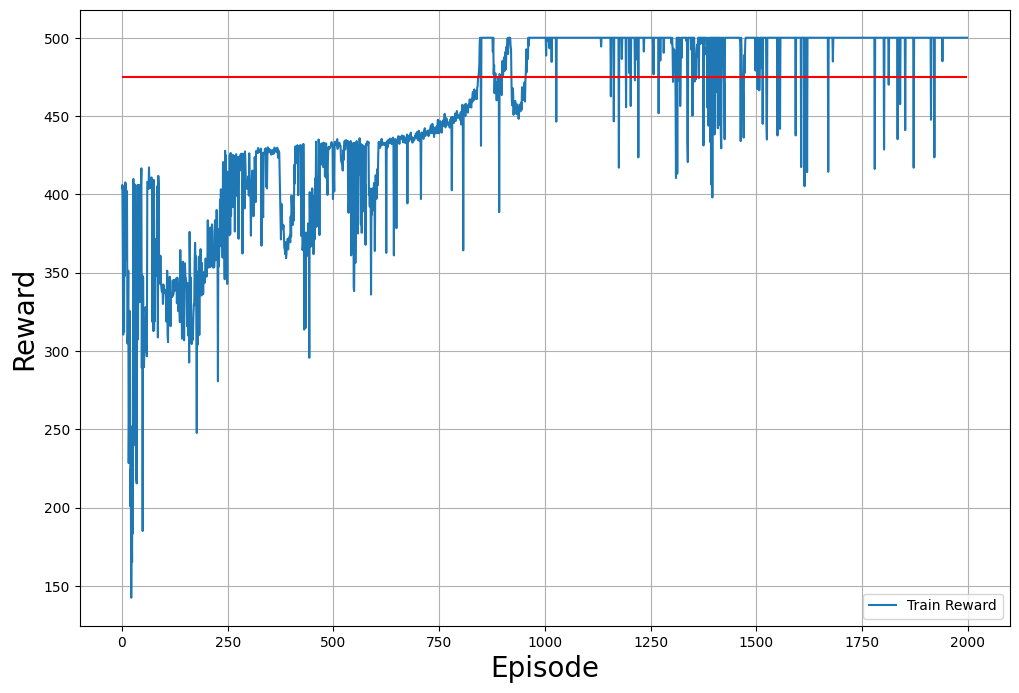

In [73]:
agent_with_baseline = Reinforce(env = env, policy = policy_for_baseline, optimizer= optimizer_for_baseline, baseline = True, seed = 1232)
mean_rewards_accross_exp_with_baseline, var_rewards_accross_exp_with_baseline, winning_episodes_for_baseline = agent_with_baseline.PerformExperiments(n_experiments = 5)


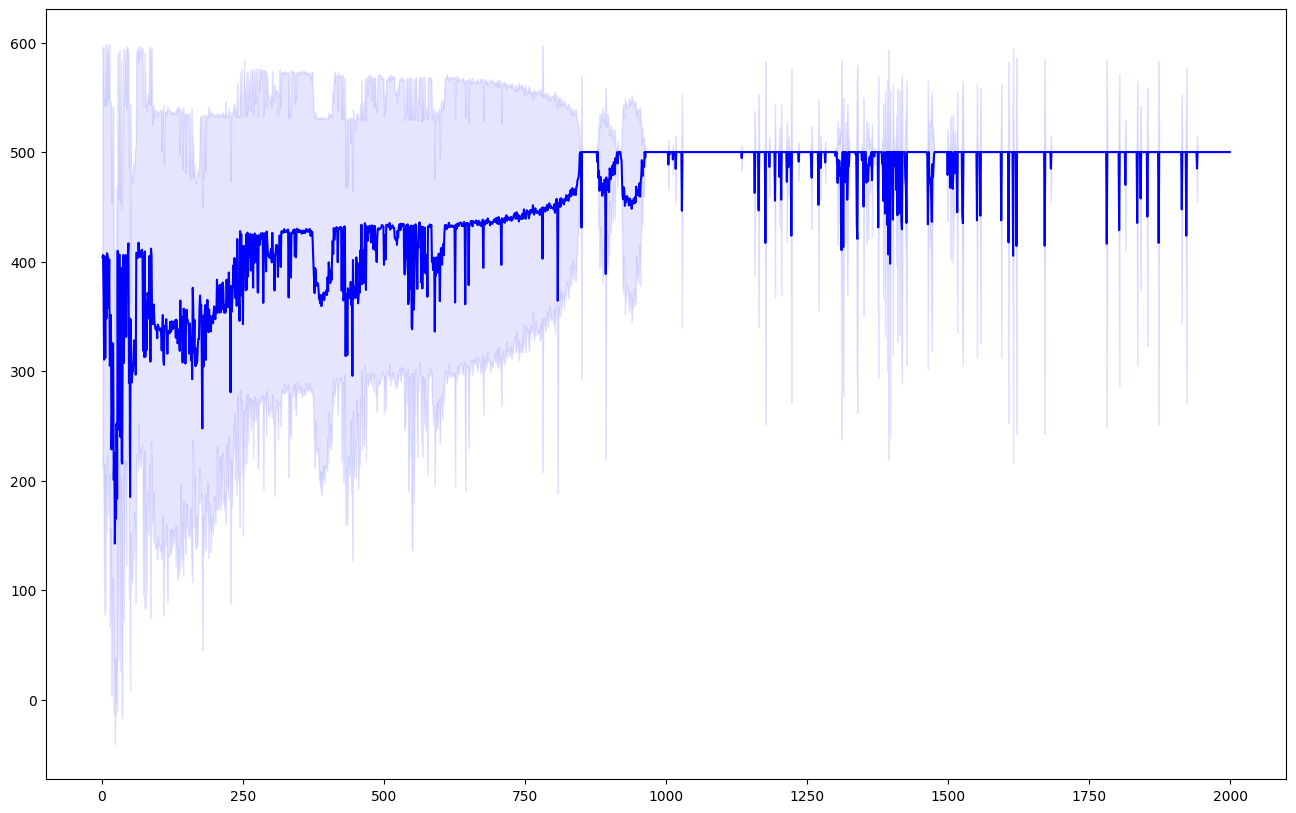

In [74]:
agent_with_baseline.Plot(mean_rewards_accross_exp_with_baseline, var_rewards_accross_exp_with_baseline)

Experiment no. :  1
Seed:  1233
| Episode: 100 | Mean Rewards: 167.0|
| Episode: 200 | Mean Rewards: 128.7|
| Episode: 300 | Mean Rewards: 128.2|
| Episode: 400 | Mean Rewards: 319.7|
Reached reward threshold in 494 episodes
| Episode: 500 | Mean Rewards: 470.2|
| Episode: 600 | Mean Rewards: 435.8|
| Episode: 700 | Mean Rewards: 464.9|
| Episode: 800 | Mean Rewards: 483.4|
| Episode: 900 | Mean Rewards: 487.1|
| Episode: 1000 | Mean Rewards: 499.5|
| Episode: 1100 | Mean Rewards: 490.7|
| Episode: 1200 | Mean Rewards: 489.1|
| Episode: 1300 | Mean Rewards: 457.6|
| Episode: 1400 | Mean Rewards: 494.3|
| Episode: 1500 | Mean Rewards: 496.9|
| Episode: 1600 | Mean Rewards: 499.9|
| Episode: 1700 | Mean Rewards: 500.0|
| Episode: 1800 | Mean Rewards: 500.0|
| Episode: 1900 | Mean Rewards: 500.0|
Experiment no. :  2
Seed:  1234
| Episode: 100 | Mean Rewards:  18.4|
| Episode: 200 | Mean Rewards:  17.3|
| Episode: 300 | Mean Rewards:  18.9|
| Episode: 400 | Mean Rewards:  18.7|
| Episode: 

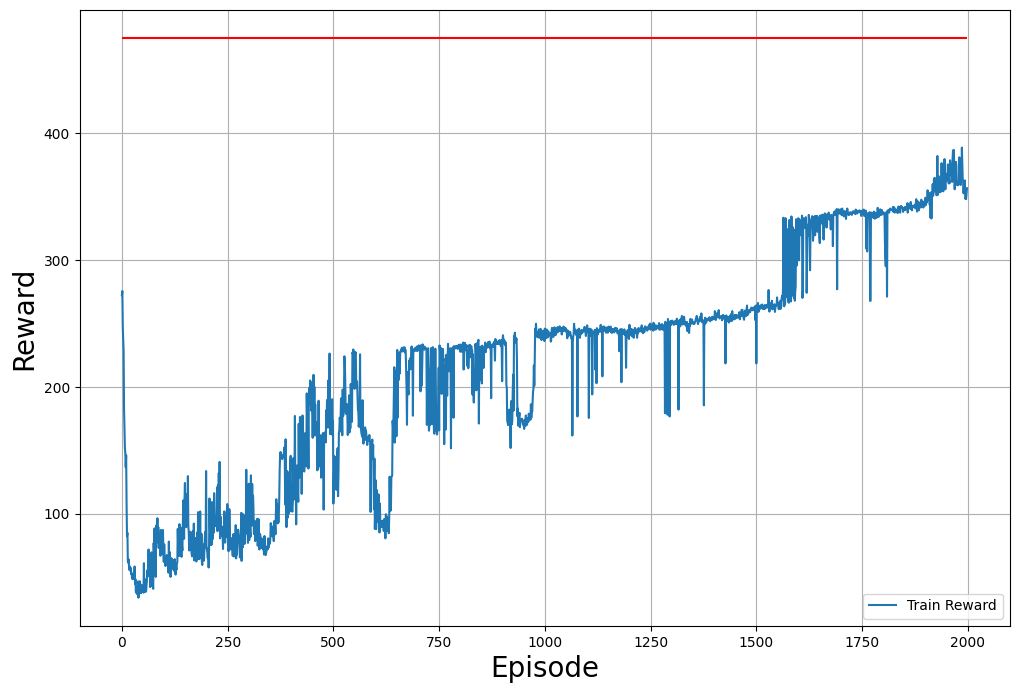

In [60]:
agent_without_baseline = Reinforce(env = env, policy = policy_without_baseline, optimizer = optimizer_without_baseline, baseline = False, seed = 1232)
mean_rewards_accross_exp_without_baseline, var_rewards_accross_exp_without_baseline, winnning_episodes_without_baseline = agent_without_baseline.PerformExperiments(n_experiments = 5)


In [78]:
print((winnning_episodes_without_baseline))
print(winning_episodes_for_baseline)

[494, 0, 706, 0, 1669]
[357, 84, 96, 937, 124]


### Plot comparing the results with/without baseline

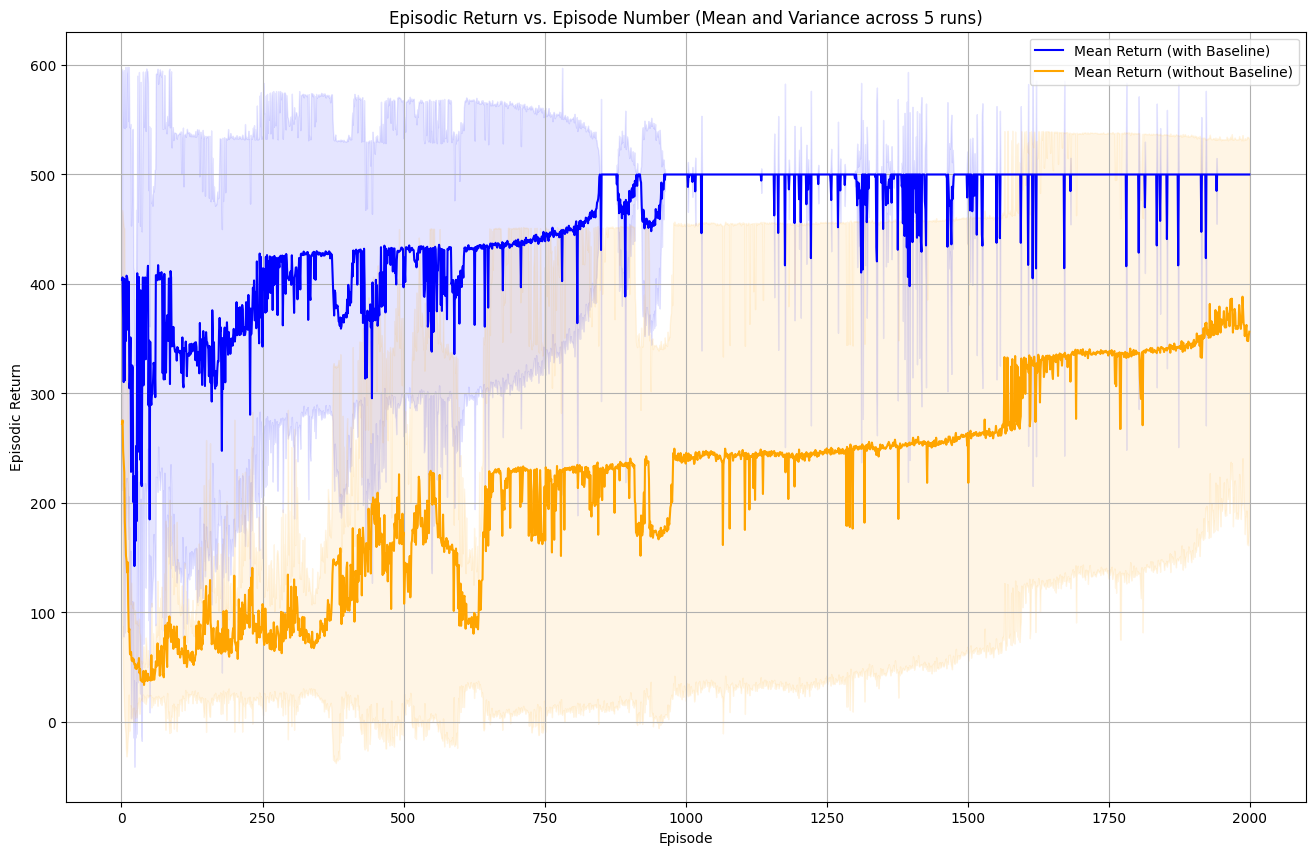

In [76]:
# Plot mean episodic return with shaded regions representing variance for variant 1
plt.plot(range(1, len(mean_rewards_accross_exp_with_baseline) + 1), mean_rewards_accross_exp_with_baseline, label='Mean Return (with Baseline)', color='blue')
plt.fill_between(range(1, len(mean_rewards_accross_exp_with_baseline) + 1), mean_rewards_accross_exp_with_baseline - np.sqrt(var_rewards_accross_exp_with_baseline),
                 mean_rewards_accross_exp_with_baseline + np.sqrt(var_rewards_accross_exp_with_baseline), color='blue', alpha=0.1)

# Plot mean episodic return with shaded regions representing variance for variant 2
plt.plot(range(1, len(mean_rewards_accross_exp_without_baseline) + 1), mean_rewards_accross_exp_without_baseline, label='Mean Return (without Baseline)', color='orange')
plt.fill_between(range(1, len(mean_rewards_accross_exp_without_baseline) + 1), mean_rewards_accross_exp_without_baseline - np.sqrt(var_rewards_accross_exp_without_baseline),
                 mean_rewards_accross_exp_without_baseline + np.sqrt(var_rewards_accross_exp_without_baseline), color='orange', alpha=0.1)

plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episode Number (Mean and Variance across 5 runs)')
plt.legend()
plt.grid(True)
plt.show()

### Plot for Moving Average of last 100 episodes

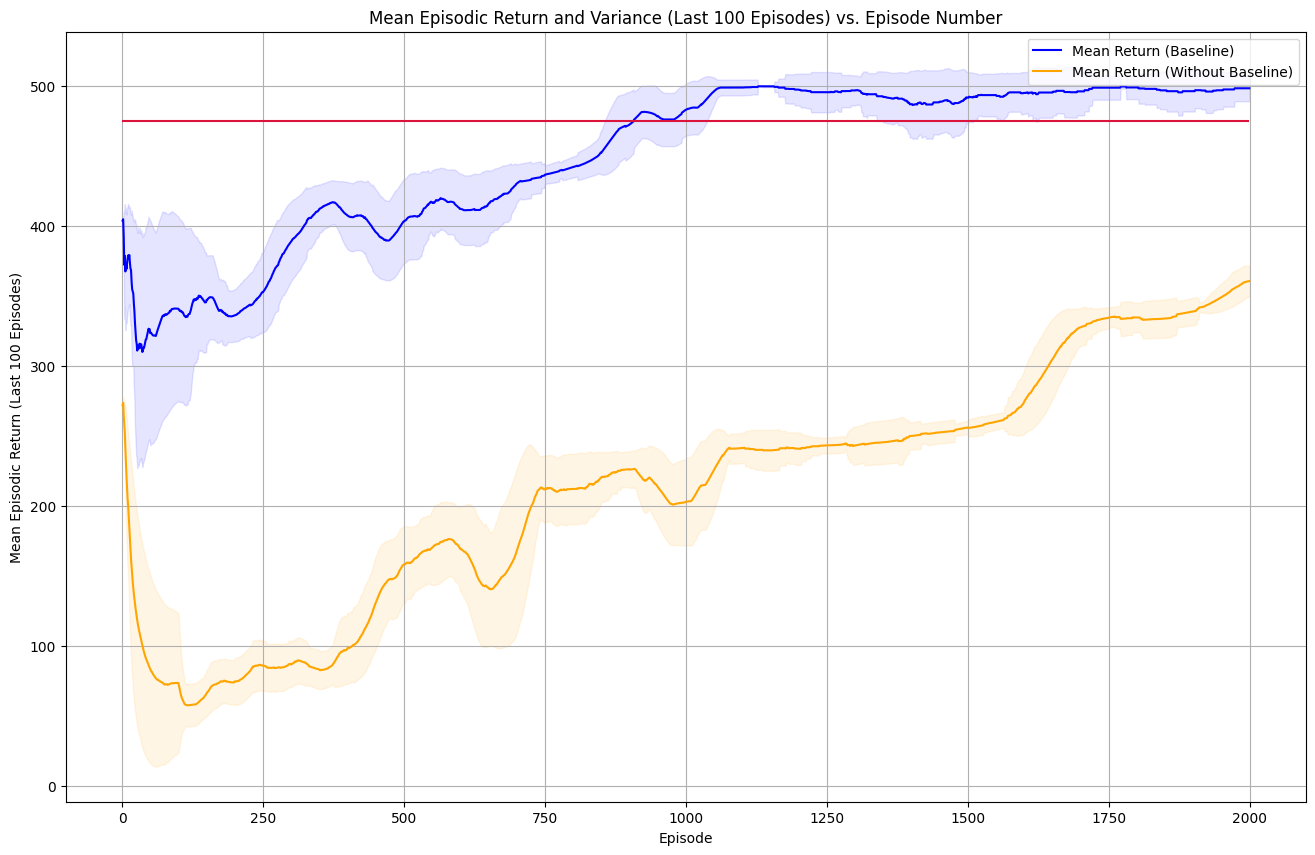

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate mean average and variance for last 100 episodes
def calculate_last_100_stats(data):
    last_100_mean = np.mean(data[-100:])
    last_100_var = np.var(data[-100:])
    return last_100_mean, last_100_var

# Initialize lists to hold mean rewards and variances for both types
mean_rewards_1_last_100 = []
variance_rewards_1_last_100 = []
mean_rewards_2_last_100 = []
variance_rewards_2_last_100 = []

# Iterate over episodes
for episode in range(1, len(mean_rewards_accross_exp_with_baseline) + 1):
    # Calculate mean average and variance for last 100 episodes for both types
    mean_1_last_100, var_1_last_100 = calculate_last_100_stats(mean_rewards_accross_exp_with_baseline[:episode])
    mean_2_last_100, var_2_last_100 = calculate_last_100_stats(mean_rewards_accross_exp_without_baseline[:episode])
    
    # Append to lists
    mean_rewards_1_last_100.append(mean_1_last_100)
    variance_rewards_1_last_100.append(var_1_last_100)
    mean_rewards_2_last_100.append(mean_2_last_100)
    variance_rewards_2_last_100.append(var_2_last_100)

# Plot mean average and variance for last 100 episodes
plt.plot(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100, label='Mean Return (Baseline)', color='blue')
plt.fill_between(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100 - np.sqrt(variance_rewards_1_last_100),
                 mean_rewards_1_last_100 + np.sqrt(variance_rewards_1_last_100), color='blue', alpha=0.1)

plt.plot(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100, label='Mean Return (Without Baseline)', color='orange')
plt.fill_between(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100 - np.sqrt(variance_rewards_2_last_100),
                 mean_rewards_2_last_100 + np.sqrt(variance_rewards_2_last_100), color='orange', alpha=0.1)

plt.xlabel('Episode')
plt.ylabel('Mean Episodic Return (Last 100 Episodes)')
plt.title('Mean Episodic Return and Variance (Last 100 Episodes) vs. Episode Number')
plt.hlines(REWARD_THRESHOLD, 0, len(mean_rewards_accross_exp_with_baseline), color='crimson')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
print(np.var(var_rewards_accross_exp_with_baseline))
print(np.var(var_rewards_accross_exp_without_baseline))

167333909.89475358
247499798.56776202
